# Does Ms at nodes represent the cell-volume weighted Ms?

**Purpose**: TODO!

**Other topics touched**

**Author and creation date**: Weiwei Wang, Jan 2013

**Modifications by**:

To start we consider a 2d square mesh with three materials disributed in four quadrants: the first quadrant filled with material1, the second and the third quadrants are material2 and the last quadrant is material3. 

In [5]:
#IPYTHON_TEST_IGNORE_OUTPUT
import dolfin as df
import numpy as np
from finmag.util.meshes import plot_mesh

mesh = df.UnitSquareMesh(2, 2,'left')

class Mat1(df.SubDomain):
    def inside(self, x, on_boundary):
        return True if x[0] >= 0.5 and x[1] >= 0.5 else False

class Mat2(df.SubDomain):
    def inside(self, x, on_boundary):
        return True if x[0] <= 0.5 else False

class Mat3(df.SubDomain):
    def inside(self, x, on_boundary):
        return True if x[0] >= 0.5 and x[1] <= 0.5 else False

subdomains = df.MeshFunction('size_t', mesh, 2)
subdomain1 = Mat1()
subdomain1.mark(subdomains, 0)
subdomain2 = Mat2()
subdomain2.mark(subdomains, 1)
subdomain3 = Mat3()
subdomain3.mark(subdomains, 2)
    
V0 = df.FunctionSpace(mesh, 'DG', 0)
Ms_dg  = df.Function(V0)
    
    
Ms1,Ms2,Ms3=[1,3,7]
Ms_values = [Ms1,Ms2,Ms3]
for cell_no in range(len(subdomains.array())):
    subdomain_no = subdomains.array()[cell_no]
    Ms_dg.vector()[cell_no] = Ms_values[subdomain_no]

plot_mesh(mesh,dg_fun=Ms_dg)

[2014-09-12 16:02:49] DEBUG: Creating new figure with figsize 'None'


As we can see, the unit square makes up 8 triangles with uniform area A=1/8=0.125, so the area of first node is 1/3*A=0.04166667, and the area for second node is 1/3*A*3=0.125 since there are 3 triangles sharing the same node. According to this rule, we can compute volumes of nodes=[1,3,2,3,6,3,2,3,1]*1/3*A=[ 0.04166667  0.125       0.08333333  0.125       0.25        0.125
  0.08333333  0.125       0.04166667];
Indeed, the node volumes for nodes are

In [6]:
S1 = df.FunctionSpace(mesh, "Lagrange", 1)
volumes = df.assemble(df.TestFunction(S1) * df.dx).array()
print volumes

[ 0.04166667  0.125       0.08333333  0.125       0.25        0.125
  0.08333333  0.125       0.04166667]


The saturation magnetisation for three materials are Ms1, Ms2 and Ms3, respectively. 
If the volumes are computed with impact of saturation magnetisation, we expect the results are [Ms2,2*Ms2+Ms3,2*Ms3,3*Ms2,Ms1+3*Ms2+2*Ms3,2*Ms1+Ms3,2*Ms2,Ms2+2*Ms1,Ms1]*1/3*A, which gives

In [8]:
A = 0.125
Ms_expect_v = np.array([Ms2, 2*Ms2+Ms3, 2*Ms3, 3*Ms2, Ms1+3*Ms2+2*Ms3, 2*Ms1+Ms3, 2*Ms2,Ms2+2*Ms1, Ms1])*1.0/3*A
Ms_cg_v = df.assemble(Ms_dg*df.TestFunction(S1)* df.dx).array()
print "Values are as expected: {}".format(np.allclose(Ms_expect_v, Ms_cg_v))

Values are as expected: True


Therefore, the magnetisation on nodes are calculated by Ms_volume_node/volume_per_node, which is the volume-weighted Ms.

In [9]:
print Ms_cg_v/volumes

[ 3.          4.33333333  7.          3.          4.          3.          3.
  1.66666667  1.        ]


### Some plots about DG and CG space

The following picture shows the difference between Ms in DG space and CG space.

/usr/lib/pymodules/python2.7/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


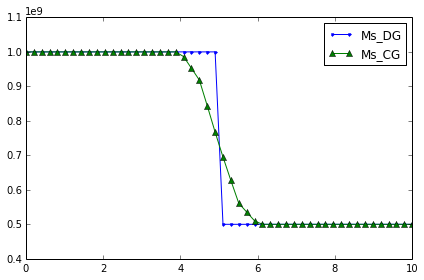

In [11]:

import numpy as np
import dolfin as df
import matplotlib.pyplot as plt
from finmag.util import helpers
from finmag.util import meshes

%matplotlib inline

mesh = df.BoxMesh(0, 0, 0, 10, 10, 1,10,10,1)


def left(coords):
    if coords[0]<5: 
        return True
    else:
        return False
    
def right(coords):
    return not left(coords)

def init_Ms(coords):
    if left(coords):
        return 10e8
    else:
        return 5e8
    

Ms_dg=helpers.scalar_valued_dg_function(init_Ms, mesh)
Ms_cg=df.Function(df.FunctionSpace(mesh, "Lagrange", 1))

S1=df.FunctionSpace(mesh, "Lagrange", 1)
S3=df.VectorFunctionSpace(mesh, "Lagrange", 1, dim=3)
volumes = df.assemble(df.TestFunction(S1) * df.dx)
Ms_cg_v=df.assemble(Ms_dg*df.TestFunction(S1)* df.dx).array()/volumes
Ms_cg.vector().set_local(Ms_cg_v)

xs=np.linspace(0,10)
Ms_dgs=[Ms_dg(x,0.5,0.5) for x in xs]
Ms_cgs=[Ms_cg(x,0.5,0.5) for x in xs]

plt.plot(xs,Ms_dgs,'.-',label='Ms_DG')
plt.plot(xs,Ms_cgs,'^-',label='Ms_CG')
plt.ylim([0.4e9,1.1e9])
plt.legend()

[2014-09-12 16:04:20] INFO: Finmag logging output will be written to file: '/home/mb4e10/finmag/doc/ipython_notebooks_src/unnamed.log' (any old content will be overwritten).
[2014-09-12 16:04:20] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2014-09-12 16:04:20] INFO: Creating Sim object 'unnamed' (rank=0/1).
[2014-09-12 16:04:20] INFO: <Mesh of topological dimension 3 (tetrahedra) with 242 vertices and 600 cells, ordered>
[2014-09-12 16:04:20] DEBUG: Creating LLG object.
[2014-09-12 16:04:20] DEBUG: Creating Demag object with solver 'FK'.
[2014-09-12 16:04:20] DEBUG: Adding interaction Demag to simulation.
[2014-09-12 16:04:20] DEBUG: Using Krylov solver for demag.
[2014-09-12 16:04:20] DEBUG: Boundary element matrix uses 0.45 MB of memory.


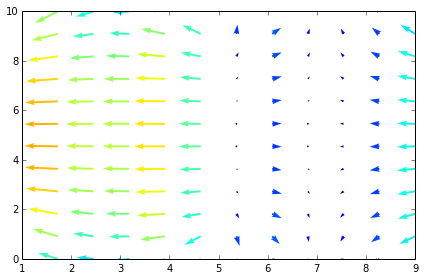

In [13]:
from finmag.energies import Demag
from finmag import Simulation as Sim

sim = Sim(mesh, Ms=Ms_dg, unit_length=1e-9)
sim.set_m((1,0,0))
sim.add(Demag())

vf=df.Function(S3)
field=sim.effective_field()
vf.vector().set_local(field)

def plot_field(vf):
    nx,ny=12,12
    X, Y= np.mgrid[1:9:nx*1j,0:10:ny*1j]

    U = np.empty((nx, ny))
    V = np.empty((nx, ny))

    for i in xrange(nx):
        for j in xrange(ny):
            U[i,j]=vf(X[i,j],Y[i,j],0.5)[0]
            V[i,j]=vf(X[i,j],Y[i,j],0.5)[1]
    R=np.sqrt(U**2+V**2)
    plt.quiver(X,Y,U,V,R)
plot_field(vf)

The above picture shows the demagnetisation fields for different materials (Ms are defined through init_Ms function), As a comparison, the demagnetisation fields for one material is plotted in the following picture.    

[2014-09-12 16:04:23] INFO: Finmag logging output will be written to file: '/home/mb4e10/finmag/doc/ipython_notebooks_src/unnamed.log' (any old content will be overwritten).
[2014-09-12 16:04:23] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2014-09-12 16:04:23] INFO: Creating Sim object 'unnamed' (rank=0/1).
[2014-09-12 16:04:23] INFO: <Mesh of topological dimension 3 (tetrahedra) with 242 vertices and 600 cells, ordered>
[2014-09-12 16:04:23] DEBUG: Creating LLG object.
[2014-09-12 16:04:23] DEBUG: Creating Demag object with solver 'FK'.
[2014-09-12 16:04:23] DEBUG: Adding interaction Demag to simulation.
[2014-09-12 16:04:23] DEBUG: Using Krylov solver for demag.
[2014-09-12 16:04:23] DEBUG: Boundary element matrix uses 0.45 MB of memory.


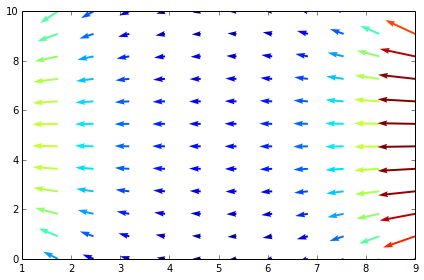

In [14]:
sim = Sim(mesh, Ms=10e8, unit_length=1e-9)
sim.set_m((1,0,0))
sim.add(Demag())

vf=df.Function(S3)
field=sim.effective_field()
vf.vector().set_local(field)
plot_field(vf)